# Epsilon Greedy class

In [1]:
import numpy as np

# new class: takes into account exponential weighted moving average
class BanditArm:

    def __init__(self, all_p, rate, period, alpha):
        self.all_p = all_p
        self.p = self.all_p[0]
        self.p_estimate = 0.
        self.N = 0.
        self.rate = rate
        self.p_estimate_ecpm = 0.
        
        self.rewards = []
        self.revenues = []

        self.period = period
        self.alpha = alpha
        
        self.ewma = 0.
        self.ewma_ecpm = 0.

    def pull(self):
        x = np.random.random() < self.p
        self.rewards.append(x)
        self.revenues.append(x * self.rate)
        if len(self.rewards) > 0 and len(self.rewards) % self.period == 0:
            if self.ewma == 0:
                self.ewma = sum(self.rewards)/self.period
            else:
                self.ewma = self.ewma * (1-self.alpha) + np.mean(self.rewards[-3:]) * self.alpha
            self.ewma_ecpm = self.ewma * self.rate * 1000
        return x

    def update(self, x):
        self.N += 1.
        self.p_estimate = ((self.N - 1) * self.p_estimate + x) / self.N
        self.p_estimate_ecpm = self.p_estimate * self.rate * 1000
        
    def update_p(self, cursor_p):
        self.p = self.all_p[cursor_p]

# Problem Conditions

In [11]:
num_trials = 3000

EPSILON = 0.1

periods = [3,4,5,6,7,8,9,10]

alphas = [0.3,0.4,0.5,0.6,0.7,0.8]

"""
a = [0.2, 0.8, 0.3]
b = [0.9, 0.7, 0.1]
c = [0.3, 0.4, 0.4]
""" 

a_p, a_rate = [0.2, 0.8, 0.2], 5
b_p, b_rate = [0.8, 0.2, 0.8], 15
c_p, c_rate = [0.5, 0.5, 0.5], 4

probabilities = [a_p, b_p, c_p]

rates = [a_rate, b_rate, c_rate]

# win rate

random_expected_win_rate = np.mean([np.mean([p[_] for p in probabilities]) for _ in range(len(probabilities))])

max_expected_win_rate = np.mean([np.max([x[_] for x in probabilities]) for _ in range(len(probabilities))])

max_uplift_win_rate = round(max_expected_win_rate / random_expected_win_rate, 2)

print(f'win rate: {random_expected_win_rate, max_expected_win_rate, max_uplift_win_rate}')

# ecpm

# compute random expected return
a = np.mean([p * a_rate for p in a_p])
b = np.mean([p * b_rate for p in b_p])
c = np.mean([p * c_rate for p in c_p])

random_expected_ecpm = round(np.mean([a, b, c]) * 1000)

# compute max expected return
first = max([p[0] * r for p, r in zip(probabilities, rates)])
second = max([p[1] * r for p, r in zip(probabilities, rates)])
third = max([p[2] * r for p, r in zip(probabilities, rates)])

max_expected_ecpm = round(np.mean([first, second, third]) * 1000)
        
# compute max uplift
max_uplift_ecpm = round(max_expected_ecpm / random_expected_ecpm, 2)

print(f'ecpm: {random_expected_ecpm, max_expected_ecpm, max_uplift_ecpm}')

win rate: (0.5, 0.8000000000000002, 1.6)
ecpm: (4333.0, 9333.0, 2.15)


# Baseline: Epsilon Greedy Win Rate (10%)

In [12]:
# datasets - 1000 Mean 1 - 2000 Mean 2 - 3000 Mean 3

uplift_win_rate_avg = 0

for _ in range(50):

    bandits = [BanditArm(p, 1, 1, 1) for p in probabilities]

    bandits_counter = {k: [0,0,0] for k in range(len(bandits))}

    rewards = np.zeros(num_trials)
    
    cursor_p = 0

    for i in range(1, num_trials):

        if i % 1000 == 0:

            cursor_p += 1

            for b in bandits:

                b.update_p(cursor_p)

        if np.random.random() < EPSILON:

            j = np.random.randint(len(bandits))

        else:

            j = np.argmax([b.p_estimate for b in bandits])

        # add 1 to bandit counter
        bandits_counter[j][cursor_p] += 1

        x = bandits[j].pull()

        rewards[i] = x
                
        bandits[j].update(x)
        
    cumulated_win_rate = sum(rewards) / len(rewards)
    
    uplift_win_rate = cumulated_win_rate / random_expected_win_rate

    uplift_win_rate_avg = (uplift_win_rate_avg * _ + uplift_win_rate) / (_+1)
    
performance_win_rate = uplift_win_rate_avg / max_uplift_win_rate

print(f'performance: {round(performance_win_rate*100,2)}%')

performance: 72.52%


# Experiment: Epsilon Greedy EWMA

In [13]:
# datasets - 1000 Mean 1 - 2000 Mean 2 - 3000 Mean 3

d = {'periods': [], 'alphas': [], 'uplifts': [], 'performances': []}

for period in periods:
    
    for alpha in alphas:
        
        uplift_ewma_avg = 0
        
        for _ in range(50):
                
            bandits = [BanditArm(p, 1, period, alpha) for p in probabilities]

            bandits_counter = {k: [0,0,0] for k in range(len(bandits))}

            rewards = np.empty(num_trials)
            
            cursor_p = 0

            for i in range(1, num_trials):

                if i % 1000 == 0:

                    cursor_p += 1

                    for b in bandits:

                        b.update_p(cursor_p)

                if np.random.random() < EPSILON:

                    j = np.random.randint(len(bandits))

                else:

                    j = np.argmax([b.ewma for b in bandits])

                # add 1 to bandit counter
                bandits_counter[j][cursor_p] += 1

                x = bandits[j].pull()

                rewards[i] = x
                                
                bandits[j].update(x)
                
            cumulated_win_rate = sum(rewards) / len(rewards)
    
            uplift_ewma = cumulated_win_rate / random_expected_win_rate

            uplift_ewma_avg = (uplift_ewma_avg * _ + uplift_ewma) / (_+1)
                        
        performance_ewma_avg = uplift_ewma_avg / max_uplift_win_rate
                                    
        print(f'period: {period}', 
              f'alpha: {alpha}', 
              f'uplift_ewma_avg: {round(uplift_ewma_avg,3)}', 
              f'performance_ewma_avg: {round(performance_ewma_avg*100,2)}%')
                
        d['periods'].append(period)
        d['alphas'].append(alpha)
        d['uplifts'].append(uplift_ewma_avg)
        d['performances'].append(performance_ewma_avg)

period: 3 alpha: 0.3 uplift_ewma_avg: 1.461 performance_ewma_avg: 91.32%
period: 3 alpha: 0.4 uplift_ewma_avg: 1.463 performance_ewma_avg: 91.46%
period: 3 alpha: 0.5 uplift_ewma_avg: 1.466 performance_ewma_avg: 91.62%
period: 3 alpha: 0.6 uplift_ewma_avg: 1.452 performance_ewma_avg: 90.76%
period: 3 alpha: 0.7 uplift_ewma_avg: 1.447 performance_ewma_avg: 90.42%
period: 3 alpha: 0.8 uplift_ewma_avg: 1.452 performance_ewma_avg: 90.74%
period: 4 alpha: 0.3 uplift_ewma_avg: 1.438 performance_ewma_avg: 89.9%
period: 4 alpha: 0.4 uplift_ewma_avg: 1.451 performance_ewma_avg: 90.67%
period: 4 alpha: 0.5 uplift_ewma_avg: 1.438 performance_ewma_avg: 89.89%
period: 4 alpha: 0.6 uplift_ewma_avg: 1.446 performance_ewma_avg: 90.36%
period: 4 alpha: 0.7 uplift_ewma_avg: 1.437 performance_ewma_avg: 89.82%
period: 4 alpha: 0.8 uplift_ewma_avg: 1.429 performance_ewma_avg: 89.34%
period: 5 alpha: 0.3 uplift_ewma_avg: 1.413 performance_ewma_avg: 88.3%
period: 5 alpha: 0.4 uplift_ewma_avg: 1.429 performan

In [14]:
import pandas as pd

df = pd.DataFrame(d)

df.head()

,periods,alphas,uplifts,performances
0,3,0.3,1.461093,0.913183
1,3,0.4,1.463387,0.914617
2,3,0.5,1.465920,0.916200
3,3,0.6,1.452133,0.907583
4,3,0.7,1.446707,0.904192


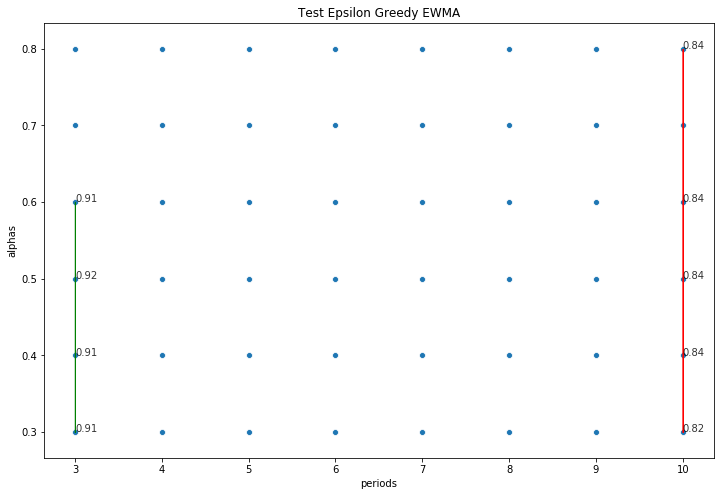

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='periods', y='alphas')
plt.title(f"Test Epsilon Greedy EWMA")
plt.xlabel('periods')
plt.ylabel('alphas')

# top4 performances
for i in range(df.shape[0]):
    if df.loc[i,'performances'] >= min(sorted(df['performances'], reverse=True)[:4]):
        plt.text(df.periods[i], y=df.alphas[i], s=round(df.performances[i],2), alpha=0.8)
        x_values = np.linspace(
            min(df.sort_values(by='performances', ascending=False)['periods'][:4]),
            max(df.sort_values(by='performances', ascending=False)['periods'][:4]),
            1000)
        plt.gca().fill_between(
            x_values, 
            min(df.sort_values(by='performances', ascending=False)['alphas'][:4]),
            max(df.sort_values(by='performances', ascending=False)['alphas'][:4]), 
            color='green')

# bottom 4 performances
for i in range(df.shape[0]):
    if df.loc[i,'performances'] <= max(sorted(df['performances'], reverse=True)[round(df.shape[0]*.9):]):
        plt.text(df.periods[i], y=df.alphas[i], s=round(df.performances[i],2), alpha=0.8)
        x_values = np.linspace(
            min(df.sort_values(by='performances', ascending=True)['periods'][:4]),
            max(df.sort_values(by='performances', ascending=True)['periods'][:4]),
            1000)
        plt.gca().fill_between(
            x_values, 
            min(df.sort_values(by='performances', ascending=True)['alphas'][:4]),
            max(df.sort_values(by='performances', ascending=True)['alphas'][:4]), 
            color='red')

plt.show()

# Experiment: Epsilon Greedy Win Rate eCPM (Business Value)

In [16]:
# datasets - 1000 Mean 1 - 2000 Mean 2 - 3000 Mean 3

uplift_ecpm_avg = 0

for _ in range(100):

    bandits = [BanditArm(p, r, 1, 1) for p, r in zip(probabilities, rates)]

    bandits_counter = {k: [0,0,0] for k in range(len(bandits))}

    rewards = list()
    
    revenues = list()

    cursor_p = 0

    for i in range(1, num_trials):

        if i % 1000 == 0:

            cursor_p += 1

            for b in bandits:

                b.update_p(cursor_p)

        if np.random.random() < EPSILON:

            j = np.random.randint(len(bandits))

        else:

            j = np.argmax([b.p_estimate_ecpm for b in bandits])

        # add 1 to bandit counter
        bandits_counter[j][cursor_p] += 1

        x = bandits[j].pull()

        rewards.append(x)
        
        revenues.append(x * bandits[j].rate)
        
        bandits[j].update(x)
        
    cumulated_ecpm = sum(revenues) * 1000 / len(revenues)
    
    uplift_ecpm = cumulated_ecpm / random_expected_ecpm

    uplift_ecpm_avg = (uplift_ecpm_avg * _ + uplift_ecpm) / (_+1)
    
performance_ecpm = uplift_ecpm_avg / max_uplift_ecpm

print(f'uplift_ecpm_avg: {round(uplift_ecpm_avg,2)}, performance_ecpm: {round(performance_ecpm*100,2)}%')

uplift_ecpm_avg: 1.95, performance_ecpm: 90.55%


# Experiment: Epsilon Greedy EWMA eCPM

In [17]:
# datasets - 1000 Mean 1 - 2000 Mean 2 - 3000 Mean 3

d = {'periods': [], 'alphas': [], 'uplifts': [], 'performances': []}

for period in periods:
    
    for alpha in alphas:
        
        uplift_ewma_ecpm_avg = 0
        
        for _ in range(50):
                
            bandits = [BanditArm(p, r, period, alpha) for p, r in zip(probabilities, rates)]

            bandits_counter = {k: [0,0,0] for k in range(len(bandits))}

            rewards = np.empty(num_trials)
            
            revenues = np.empty(num_trials)

            cursor_p = 0

            for i in range(1, num_trials):

                if i % 1000 == 0:

                    cursor_p += 1

                    for b in bandits:

                        b.update_p(cursor_p)

                if np.random.random() < EPSILON:

                    j = np.random.randint(len(bandits))

                else:

                    j = np.argmax([b.ewma_ecpm for b in bandits])

                # add 1 to bandit counter
                bandits_counter[j][cursor_p] += 1

                x = bandits[j].pull()

                rewards[i] = x
                
                revenues[i] = x * bandits[j].rate
                
                bandits[j].update(x)
                                
            cumulated_ecpm = sum(revenues) * 1000 / len(revenues)
    
            uplift_ewma_ecpm = cumulated_ecpm / random_expected_ecpm

            uplift_ewma_ecpm_avg = (uplift_ewma_ecpm_avg * _ + uplift_ewma_ecpm) / (_+1)
            
        performance_ewma_ecpm_avg = uplift_ewma_ecpm_avg / max_uplift_ecpm

        print(f'period: {period}', 
              f'alpha: {alpha}', 
              f'uplift_avg: {round(uplift_ewma_ecpm_avg,3)}', 
              f'performance: {round(performance_ewma_ecpm_avg*100,2)}%')
                
        d['periods'].append(period)
        d['alphas'].append(alpha)
        d['uplifts'].append(uplift_ewma_ecpm_avg)
        d['performances'].append(performance_ewma_ecpm_avg)

period: 3 alpha: 0.3 uplift_avg: 1.929 performance: 89.74%
period: 3 alpha: 0.4 uplift_avg: 1.945 performance: 90.46%
period: 3 alpha: 0.5 uplift_avg: 1.93 performance: 89.75%
period: 3 alpha: 0.6 uplift_avg: 1.936 performance: 90.05%
period: 3 alpha: 0.7 uplift_avg: 1.913 performance: 88.98%
period: 3 alpha: 0.8 uplift_avg: 1.929 performance: 89.73%
period: 4 alpha: 0.3 uplift_avg: 1.905 performance: 88.59%
period: 4 alpha: 0.4 uplift_avg: 1.907 performance: 88.69%
period: 4 alpha: 0.5 uplift_avg: 1.897 performance: 88.22%
period: 4 alpha: 0.6 uplift_avg: 1.905 performance: 88.62%
period: 4 alpha: 0.7 uplift_avg: 1.901 performance: 88.41%
period: 4 alpha: 0.8 uplift_avg: 1.887 performance: 87.78%
period: 5 alpha: 0.3 uplift_avg: 1.87 performance: 86.96%
period: 5 alpha: 0.4 uplift_avg: 1.896 performance: 88.18%
period: 5 alpha: 0.5 uplift_avg: 1.88 performance: 87.43%
period: 5 alpha: 0.6 uplift_avg: 1.881 performance: 87.49%
period: 5 alpha: 0.7 uplift_avg: 1.864 performance: 86.7%
p

In [18]:
import pandas as pd

df = pd.DataFrame(d)

df.head()

,periods,alphas,uplifts,performances
0,3,0.3,1.929393,0.897392
1,3,0.4,1.944928,0.904618
2,3,0.5,1.929548,0.897464
3,3,0.6,1.935997,0.900464
4,3,0.7,1.913124,0.889825


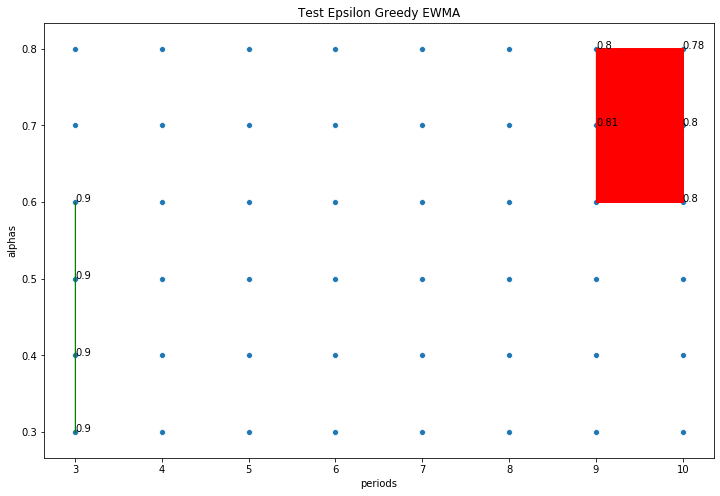

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.scatterplot(data=df, x='periods', y='alphas')
plt.title(f"Test Epsilon Greedy EWMA")
plt.xlabel('periods')
plt.ylabel('alphas')

# top4 uplifts
for i in range(df.shape[0]):
    if df.loc[i,'performances'] >= min(sorted(df['performances'], reverse=True)[:4]):
        plt.text(df.periods[i], y=df.alphas[i], s=round(df.performances[i],2))
        x_values = np.linspace(
            min(df.sort_values(by='performances', ascending=False)['periods'][:4]),
            max(df.sort_values(by='performances', ascending=False)['periods'][:4]),
            1000)
        plt.gca().fill_between(
            x_values, 
            min(df.sort_values(by='performances', ascending=False)['alphas'][:4]),
            max(df.sort_values(by='performances', ascending=False)['alphas'][:4]), 
            color='green')

# bottom 4 uplifts
for i in range(df.shape[0]):
    if df.loc[i,'performances'] <= max(sorted(df['performances'], reverse=True)[round(df.shape[0]*.9):]):
        plt.text(df.periods[i], y=df.alphas[i], s=round(df.performances[i],2))
        x_values = np.linspace(
            min(df.sort_values(by='performances', ascending=True)['periods'][:4]),
            max(df.sort_values(by='performances', ascending=True)['periods'][:4]),
            1000)
        plt.gca().fill_between(
            x_values, 
            min(df.sort_values(by='performances', ascending=True)['alphas'][:4]),
            max(df.sort_values(by='performances', ascending=True)['alphas'][:4]), 
            color='red')

plt.show()